In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pyodbc
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal

import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
host='dev-data-etl-rs.ct0xxcn9xq5g.ap-northeast-2.redshift.amazonaws.com'
dbname='data_analysis_db'
user='stella'
password='iWntan282E5jJQc'
port='5439'

In [3]:
# Redshift에 연결
conn = psycopg2.connect(
    host=host,
    dbname=dbname,
    user=user,
    password=password,
    port=port
)

In [4]:
# 커서 생성
cursor = conn.cursor()
# SQL 쿼리 실행 (예시: frigga_sample 테이블에서 모든 데이터를 조회)
cursor.execute("""                          
                    SELECT 
                        *
                    FROM 
                        "data_analysis_db"."da_schema"."t_frigga_broken_target"
                    WHERE 1=1
                    ORDER BY device_serial ASC
                ;
               """)

# 결과 가져오기
rows = cursor.fetchall()

# 컬럼명 가져오기
columns = [desc[0] for desc in cursor.description]

# DataFrame으로 변환
df_broken = pd.DataFrame(rows, columns=columns)

# 커서와 연결 종료
cursor.close()
conn.close()

In [5]:
print(df_broken.head(2))
print(df_broken.shape)

  device_serial          start_date            end_date duration_time  \
0      VC6M6002 2024-12-02 14:47:18 2024-12-11 23:37:18        224.83   
1      VC6M6003 2024-12-14 09:40:13 2025-01-23 23:50:13        974.17   

  duration_day min_temp max_temp mean_temp std_temp min_humi max_humi  \
0         9.00     1.80    21.00      9.36    11.57    48.00    80.00   
1        40.00    -0.10    19.80      6.83    14.00    37.00    66.00   

  mean_humi std_humi min_acc max_acc mean_acc std_acc q1_temp q3_temp  \
0     67.81     5.29    1.00    1.40     1.02    0.05    6.90   11.70   
1     56.53     7.61    1.00    1.52     1.02    0.06    3.90    9.00   

  temp_start temp_end q1_humi q3_humi humi_start humi_end q1_acc q3_acc  \
0      -0.30    18.90   64.00   72.00      52.00    84.00   1.00   1.00   
1      -3.75    16.65   49.00   62.00      29.50    81.50   1.00   1.01   

  acc_start acc_end ta_min ta_max ta_mean ta_std ta_q1 ta_q3 ws1_min ws1_max  \
0      1.00    1.00   0.70  16.10 

In [6]:
df_broken.columns

Index(['device_serial', 'start_date', 'end_date', 'duration_time',
       'duration_day', 'min_temp', 'max_temp', 'mean_temp', 'std_temp',
       'min_humi', 'max_humi', 'mean_humi', 'std_humi', 'min_acc', 'max_acc',
       'mean_acc', 'std_acc', 'q1_temp', 'q3_temp', 'temp_start', 'temp_end',
       'q1_humi', 'q3_humi', 'humi_start', 'humi_end', 'q1_acc', 'q3_acc',
       'acc_start', 'acc_end', 'ta_min', 'ta_max', 'ta_mean', 'ta_std',
       'ta_q1', 'ta_q3', 'ws1_min', 'ws1_max', 'ws1_mean', 'ws1_std', 'ws1_q1',
       'ws1_q3', 'ws10_min', 'ws10_max', 'ws10_mean', 'ws10_std', 'ws10_q1',
       'ws10_q3', 'hm_min', 'hm_max', 'hm_mean', 'hm_std', 'hm_q1', 'hm_q3',
       'alert_temp_sum', 'alert_humi_sum', 'alert_acc_sum', 'broken_yn'],
      dtype='object')

## BASE LINE

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [15]:
# 독립변수 / 종속변수 구분# 독립 변수와 종속 변수 정의
X = df_broken[['duration_time', 'duration_day', 'min_temp', 'max_temp', 'mean_temp', 'std_temp', 'min_humi', 'max_humi', 'mean_humi', 'std_humi', 
                'min_acc', 'max_acc', 'mean_acc', 'std_acc', 'q1_temp', 'q3_temp', 'temp_start', 'temp_end', 'q1_humi', 'q3_humi', 
                'humi_start', 'humi_end', 'q1_acc', 'q3_acc', 'acc_start', 'acc_end', 'ta_min', 'ta_max', 'ta_mean', 'ta_std', 
                'ta_q1', 'ta_q3', 'ws1_min', 'ws1_max', 'ws1_mean', 'ws1_std', 'ws1_q1', 'ws1_q3', 'ws10_min', 'ws10_max', 
                'ws10_mean', 'ws10_std', 'ws10_q1', 'ws10_q3', 'hm_min', 'hm_max', 'hm_mean', 'hm_std', 'hm_q1', 'hm_q3', 
                'alert_temp_sum', 'alert_humi_sum', 'alert_acc_sum']]

# y = df_broken['broken_yn']
y = df_broken['broken_yn'].astype(int)

In [16]:
# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 세트에 맞춰 스케일링
X_test_scaled = scaler.transform(X_test)  # 테스트 세트에 동일한 스케일링 적용

정확도: 0.9375
ROC AUC 점수: 1.0000
분류 보고서:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       0.78      1.00      0.88         7

    accuracy                           0.94        32
   macro avg       0.89      0.96      0.92        32
weighted avg       0.95      0.94      0.94        32



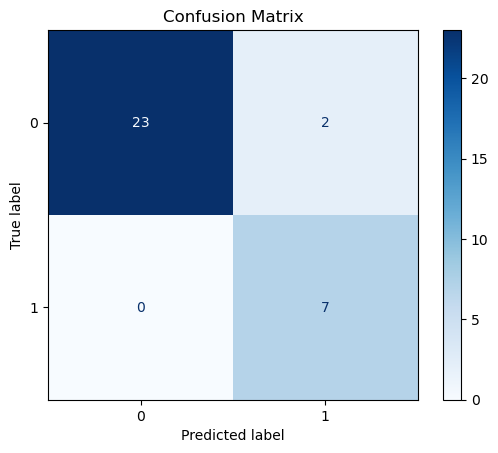

    broken_yn  predicted_proba
0           0              NaN
1           1              NaN
2           1              NaN
3           0              NaN
4           0              NaN
..        ...              ...
151         0              NaN
152         0         0.033635
153         0              NaN
154         1              NaN
155         0              NaN

[156 rows x 2 columns]


In [22]:
# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 1에 대한 확률

# 예측 결과 평가
y_pred_lr = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 결과 출력
print(f"정확도: {accuracy:.4f}")
print(f"ROC AUC 점수: {roc_auc:.4f}")
print("분류 보고서:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_lr)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 예측 확률을 데이터프레임에 추가
X_test_with_proba = X_test.copy()  # X_test의 복사본 생성
X_test_with_proba['predicted_proba'] = y_pred_proba  # 새로운 컬럼 추가

# 원래 데이터프레임에 추가 (원하는 경우)
df_broken_prob = df_broken.copy()  # 원본 데이터프레임 복사
df_broken_prob.loc[X_test.index, 'predicted_proba'] = y_pred_proba  # 예측 확률 추가

# 결과 확인
print(df_broken_prob[['broken_yn', 'predicted_proba']])

In [28]:
df_broken_prob[['broken_yn', 'predicted_proba']].to_csv('../data/probablity.csv', index=False)

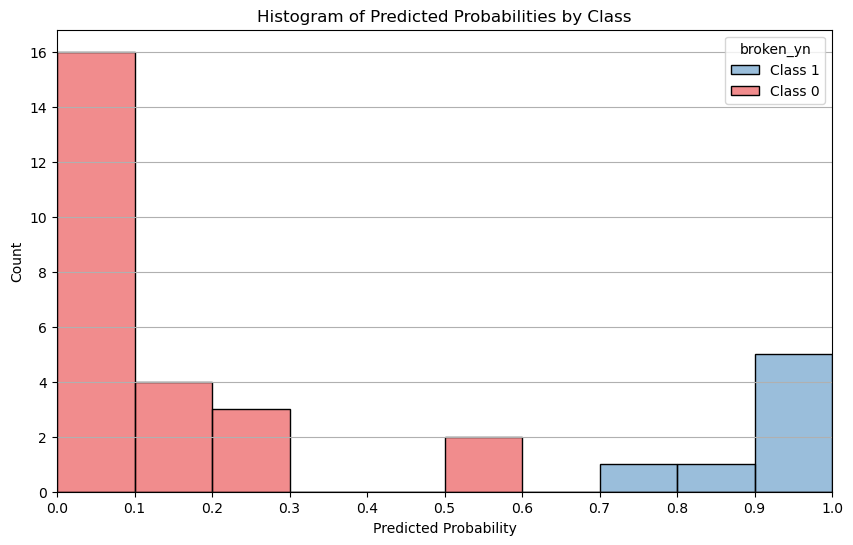

In [26]:
# 히스토그램 생성
plt.figure(figsize=(10, 6))

# seaborn의 histplot을 사용하여 히스토그램 생성
sns.histplot(data=df_broken_prob, x='predicted_proba', hue='broken_yn', 
             bins=10, stat='count', common_norm=False, alpha=0.5, 
             palette='Set1', kde=False)

# 그래프 제목 및 레이블 설정
plt.title('Histogram of Predicted Probabilities by Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.xlim(0, 1)  # x축 범위 설정
plt.xticks([i/10 for i in range(11)])  # x축 눈금 설정 (0.0, 0.1, ..., 1.0)
plt.legend(title='broken_yn', loc='upper right', labels=['Class 1', 'Class 0'])
plt.grid(axis='y')

# 그래프 출력
plt.show()

Feature Importance:
            Feature  Importance
11         max_acc    0.352934
7         max_humi    0.033619
13         std_acc    0.033253
51  alert_humi_sum    0.032489
3         max_temp    0.027648
5         std_temp    0.027270
33         ws1_max    0.025489
9         std_humi    0.023171
29          ta_std    0.022138
24       acc_start    0.022113
0    duration_time    0.020972
45          hm_max    0.019137
1     duration_day    0.018408
48           hm_q1    0.018350
47          hm_std    0.016427
26          ta_min    0.015955
44          hm_min    0.015233
39        ws10_max    0.015031
6         min_humi    0.014344
25         acc_end    0.013810
21        humi_end    0.013271
17        temp_end    0.011416
2         min_temp    0.010691
46         hm_mean    0.009448
37          ws1_q3    0.008723
30           ta_q1    0.008397
52   alert_acc_sum    0.008347
20      humi_start    0.008289
40       ws10_mean    0.008049
41        ws10_std    0.007785
36          ws1_q1

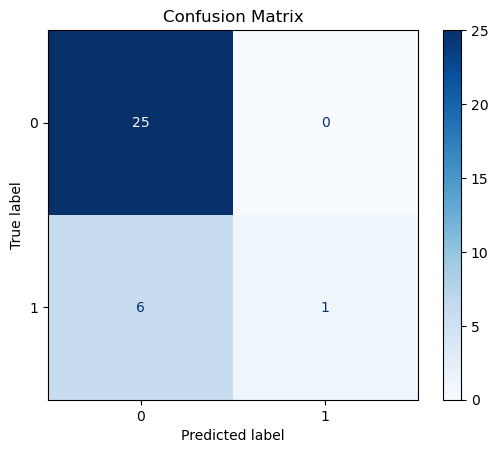

In [12]:
# 2. 랜덤 포레스트 모델
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)  # 스케일링 필요 없음
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 예측 결과 평가
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

# 변수 중요도 확인
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# 중요도가 높은 변수 출력
print("Feature Importance:\n", feature_importance)

# 결과 출력
print(f"정확도: {accuracy:.4f}")
print(f"ROC AUC 점수: {roc_auc:.4f}")
print("분류 보고서:")
print(classification_report(y_test, y_pred_rf))


# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_rf)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

정확도: 0.8125
ROC AUC 점수: 1.0000
분류 보고서:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        25
           1       1.00      0.14      0.25         7

    accuracy                           0.81        32
   macro avg       0.90      0.57      0.57        32
weighted avg       0.85      0.81      0.75        32



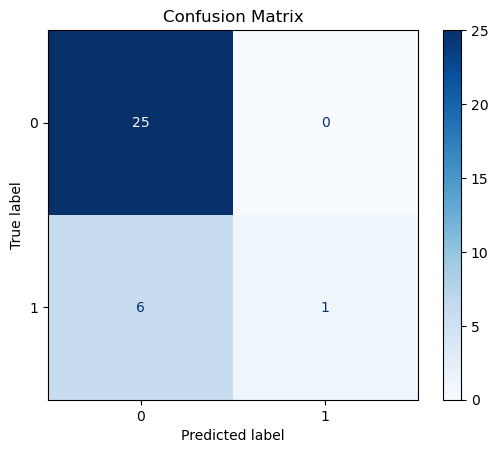

In [13]:
# 3. XGBoost 모델
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train.values, y_train.values)  # 스케일링 필요 없음
y_pred_xgb = xgb_model.predict(X_test.values)
y_pred_proba_xgb = xgb_model.predict_proba(X_test.values)[:, 1]

# 예측 결과 평가
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

# 결과 출력
print(f"정확도: {accuracy:.4f}")
print(f"ROC AUC 점수: {roc_auc:.4f}")
print("분류 보고서:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_xgb)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### 확률값으로 결과 출력

### feature 정보 가감

In [12]:
# 독립변수 / 종속변수 구분# 독립 변수와 종속 변수 정의
X = df_broken[['duration_time', 'mean_temp', 'mean_humi', 'mean_acc', 'ta_mean', 'ws1_mean', 'ws10_mean', 'alert_temp_sum', 'alert_humi_sum', 'alert_acc_sum']]
y = df_broken['broken_yn'].astype(int)

In [13]:
# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 세트에 맞춰 스케일링
X_test_scaled = scaler.transform(X_test)  # 테스트 세트에 동일한 스케일링 적용

In [15]:
# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# 예측 확률 계산
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 1에 대한 확률

# 예측 결과 평가
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 결과 출력
print(f"정확도: {accuracy:.4f}")
print(f"ROC AUC 점수: {roc_auc:.4f}")
print("분류 보고서:")
print(classification_report(y_test, y_pred))

정확도: 0.6875
ROC AUC 점수: 0.6400
분류 보고서:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        25
           1       0.20      0.14      0.17         7

    accuracy                           0.69        32
   macro avg       0.49      0.49      0.49        32
weighted avg       0.65      0.69      0.67        32

